In [106]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [107]:
DATA_ROOT = Path("../../data/private")
VIDEO_NAME = Path("VID_20230814_102451798.mp4")

# check if the video exists
if not (DATA_ROOT / VIDEO_NAME).exists():
    raise FileNotFoundError(f"Video not found: {DATA_ROOT / VIDEO_NAME}")

In [108]:
# open video file with opencv
video = cv2.VideoCapture(str(DATA_ROOT/VIDEO_NAME))

# check if video opened successfully
if (video.isOpened() == False):
    raise Exception(f"Error opening video stream or file: {DATA_ROOT/VIDEO_NAME}")
    
# print video properties
print("Video properties:")
print("  - frame width:  ", video.get(cv2.CAP_PROP_FRAME_WIDTH))
print("  - frame height: ", video.get(cv2.CAP_PROP_FRAME_HEIGHT))
print("  - frame count:  ", video.get(cv2.CAP_PROP_FRAME_COUNT))
print("  - frame rate:   ", video.get(cv2.CAP_PROP_FPS))

Video properties:
  - frame width:   1080.0
  - frame height:  1920.0
  - frame count:   91.0
  - frame rate:    30.0


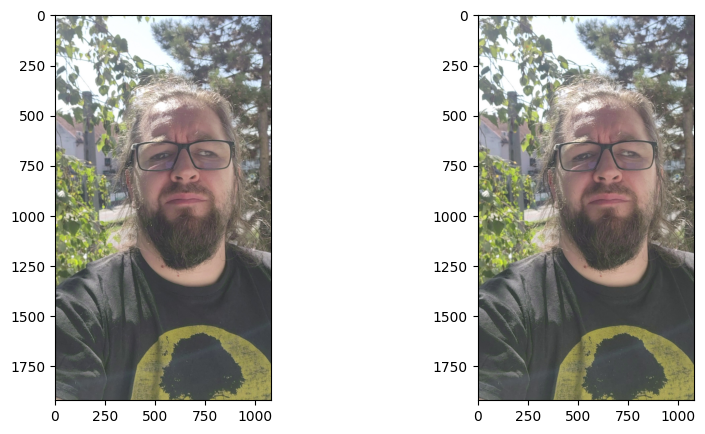

In [109]:
# reset the video reader
video.set(cv2.CAP_PROP_POS_FRAMES, 0)

# get first two frames from the video
ret, frame1 = video.read()
ret, frame2 = video.read()

# show the frames
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(frame1[..., ::-1])
ax[1].imshow(frame2[..., ::-1])
plt.show()

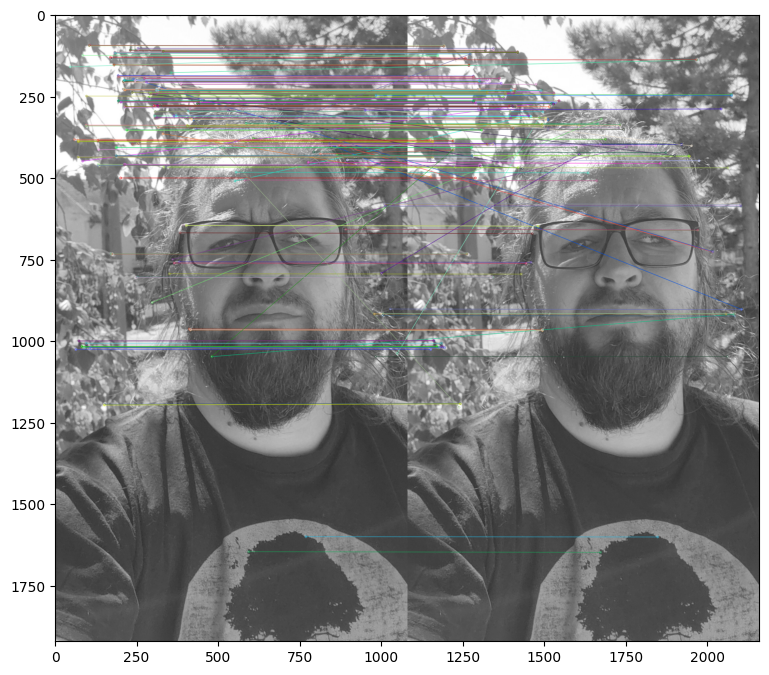

In [110]:
# Rectify the images
gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

# find keypoints and descriptors
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(gray1, None)
kp2, des2 = orb.detectAndCompute(gray2, None)

# match features
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
# matches = sorted(matches, key=lambda x: x.distance)

# draw matches
img_match = cv2.drawMatches(gray1, kp1, gray2, kp2, matches, None, flags=2)

# show images
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_match)
plt.show()



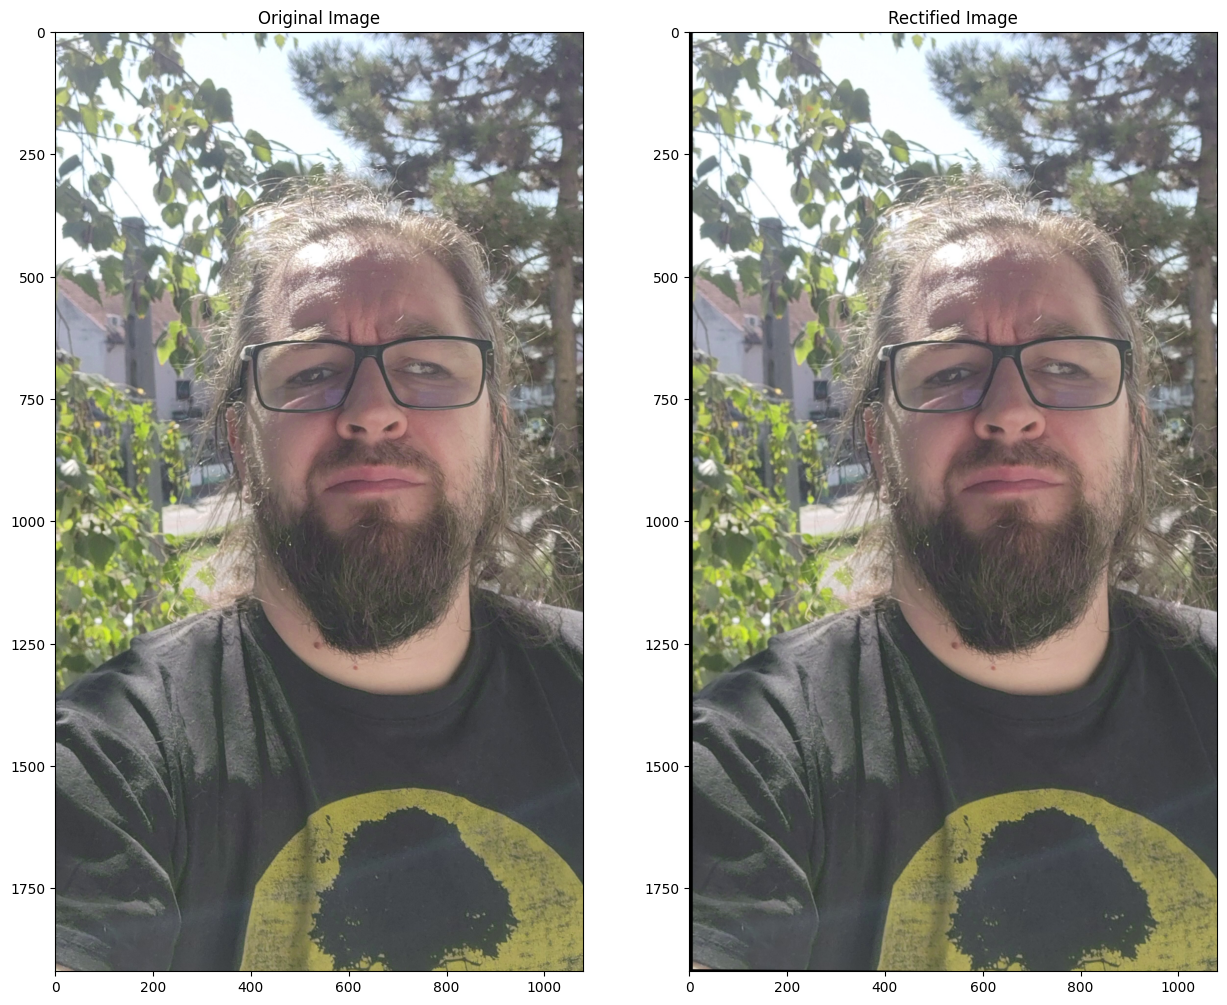

In [111]:
good_matches = matches # [:20]
matched_keypoints1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
matched_keypoints2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# calculate homography matrix
homography_matrix1 = cv2.findHomography(matched_keypoints1, matched_keypoints2, cv2.RANSAC, 5.0)[0]

# warp perspective
rectified_image1 = cv2.warpPerspective(frame1, homography_matrix1, (frame1.shape[1], frame1.shape[0]))

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(frame1[...,::-1])
ax[0].set_title('Original Image')
ax[1].imshow(rectified_image1[...,::-1])
ax[1].set_title('Rectified Image')

plt.show()

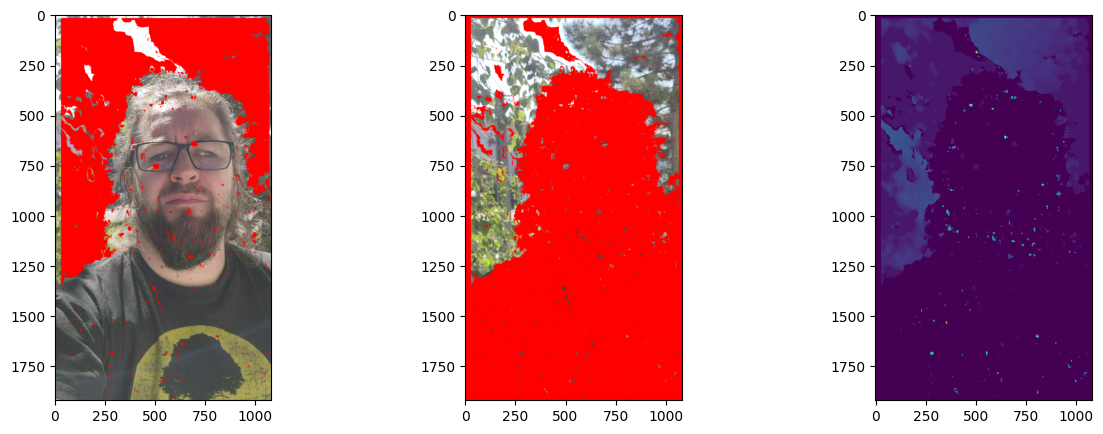

In [112]:
# calculate disparity map
stereo = cv2.StereoBM_create(numDisparities=16, blockSize=31)
gray_rectified_image1 = cv2.cvtColor(rectified_image1, cv2.COLOR_BGR2GRAY)
disparity = stereo.compute(gray2, gray_rectified_image1)

DISPARITY_THRESHOLD = 0
# background_mask = (disparity < DISPARITY_THRESHOLD).astype(np.uint8)
foreground_mask = np.where(disparity >= DISPARITY_THRESHOLD)
background_mask = np.where(disparity < DISPARITY_THRESHOLD)

foreground = frame2.copy()
foreground[foreground_mask] = (0, 0, 255)
background = frame2.copy()
background[background_mask] = (0, 0, 255)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(foreground[..., ::-1])
ax[1].imshow(background[..., ::-1])
ax[2].imshow(disparity)
plt.show()